In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from DataProcessor import DataProcessor
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler
from Model import GaussianNaiveBayes
from Model import QuadraticDiscriminantAnalysis
# from Metrics import Metrics
from sklearn.metrics import accuracy_score

from mpl_toolkits.mplot3d import Axes3D

PCA is generally better for data reconstruction because it retains the components that explain the most variance. LDA is better for class separability and may discard information that does not contribute to distinguishing between classes, which can lead to a greater loss of information during reconstruction.

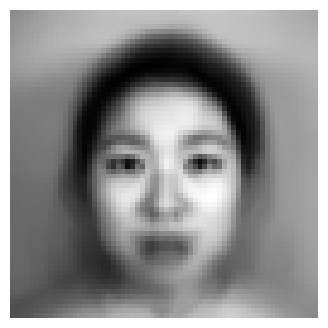

In [2]:
current_directory = os.getcwd()
image_processor = DataProcessor(current_directory)
image_processor.load_images()
image_processor.calculate_mean_image()

In [3]:
dataset = image_processor.data
images = np.array([list(img) for img in dataset['Image']])

In [4]:
labels = dataset['Expression']
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

1. For each class, calculate the mean vector which summarizes the average feature value for each feature in the class.
2. Compute the Scatter Matrices
3. Compute the Linear Discriminants: The criteria for this maximization is typically the generalized eigenvalue problem for $ S_W^{-1}S_B  $
4. Project the Data 

Limitations:
- Assumes Gaussian Distributions: Works best when the data distribution is approximately normal.
- Sensitivity to Outliers: Can be influenced heavily by outliers in the data.
- Linear Separability: Assumes that the classes can be separated by a linear boundary.

In [5]:
def data_whitening(X, mean, std):
    X = X - mean
    X = X / (std + 1e-10)
    return X

In [6]:
def inverse_data_whitening(X, mean, std):
    X = X * std
    X = X + mean
    return X

In [7]:
X, y = images, labels
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_standardized = data_whitening(X, mean, std)

Within-class scatter matrix:

$$ S_W = \sum_{i=1}^{c} S_i = \sum_{i=1}^{c} \sum_{\mathbf{x} \in D_i} (\mathbf{x} - \mathbf{m}_i)(\mathbf{x} - \mathbf{m}_i)^T $$
  

In [8]:
def within_scatter(X,y):
    Sw = np.zeros((X.shape[1], X.shape[1]))
    for i in np.unique(y):
        Xi = X[y == i]
        mean_class = np.mean(Xi, axis=0)
        Si = np.cov(Xi, rowvar=False, bias=True) * (len(Xi) - 1)
        Sw += Si
    return Sw


Between-class scatter matrix:
$$
  S_B = \sum_{i=1}^{c} N_i (\mathbf{m}_i - \mathbf{m})(\mathbf{m}_i - \mathbf{m})^T
$$

In [9]:
def between_scatter(X, y, mean_overall):
    unique_classes = np.unique(y)
    Sb = np.zeros((X.shape[1], X.shape[1]))
    for i in unique_classes:
        Xi = X[y == i]
        mean_class_i = np.mean(Xi, axis=0)
        Ni = Xi.shape[0]
        mean_diff = (mean_class_i - mean_overall).reshape(-1, 1)
        Sb += Ni * (mean_diff @ mean_diff.T)
    return Sb


In [10]:
mean_overall = np.mean(X_standardized, axis=0)

In [11]:
Sw = within_scatter(X_standardized, labels)
Sb = between_scatter(X_standardized, labels, mean_overall)

make sw and sb symmetric
to counteract any numerical instability that might result in non-symmetric scatter matrices due to floating-point errors.

In [12]:
Sw = (Sw + Sw.T) / 2
Sb = (Sb + Sb.T) / 2

Solve the Eigenvalue Problem
$$ S_W^{-1}S_B \mathbf{w} = \lambda \mathbf{w} $$



In [13]:
def regularized_inverse(matrix, alpha=0.01):
    reg_matrix = matrix + alpha * np.eye(matrix.shape[0])
    return np.linalg.pinv(reg_matrix)

In [14]:
def calculate_separability_matrix(Sw, Sb):
    Sw_inv = regularized_inverse(Sw)
    return Sw_inv.dot(Sb)

In [15]:
def plot_eigenfaces(eigenfaces):
    num_eigenfaces = len(eigenfaces)
    num_rows = int(np.ceil(num_eigenfaces / 5))
    num_columns = min(5, num_eigenfaces)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(3 * num_columns, 3 * num_rows))
    for i in range(num_rows):
        for j in range(num_columns):
            index = i * num_columns + j
            if index < num_eigenfaces:
                ax = axes[i, j] if num_rows > 1 else axes[j]
                ax.imshow(eigenfaces[index], cmap='gray')
                ax.axis('off')

    plt.show()

In [16]:
def inverse_transform(X, components, mean, std):
    return inverse_data_whitening(np.dot(X, components), mean, std)

In [17]:
def plot_inverse_transformation(reconstructed_images, unique_classes, image_size):
    
    print("inverse transform images: ")
    fig, axes = plt.subplots(2, len(unique_classes), figsize=(4* len(unique_classes),12))
    for i, class_label in enumerate(unique_classes):
        class_indices = np.where(labels == class_label)[0]
        random_index = np.random.choice(class_indices)
        original_image = images[random_index].reshape(image_size)
        reconstructed_image = reconstructed_images[random_index]

        axes[0, i].imshow(original_image, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'Class {class_label} - Original')

        axes[1,i].imshow(reconstructed_image, cmap='gray')
        axes[1,i].axis('off')
        axes[1,i].set_title(f'Class {class_label} - Reconstructed')

    plt.tight_layout()
    plt.show()

In [18]:
separability_matrix = calculate_separability_matrix(Sw, Sb)

In [19]:
eigenvalues, eigenvectors = np.linalg.eigh(separability_matrix)

In [20]:
eigenvectors = eigenvectors.T
idxs = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idxs]
eigenvectors = eigenvectors[idxs]

In [21]:
image_size = (64,64)
n_components = min(len(np.unique(labels)), eigenvectors.shape[1]) - 1 
components = np.real(eigenvectors[0:n_components])
transformed_images = X_standardized.dot(components.T)
eigenfaces = components.reshape((n_components, *image_size))

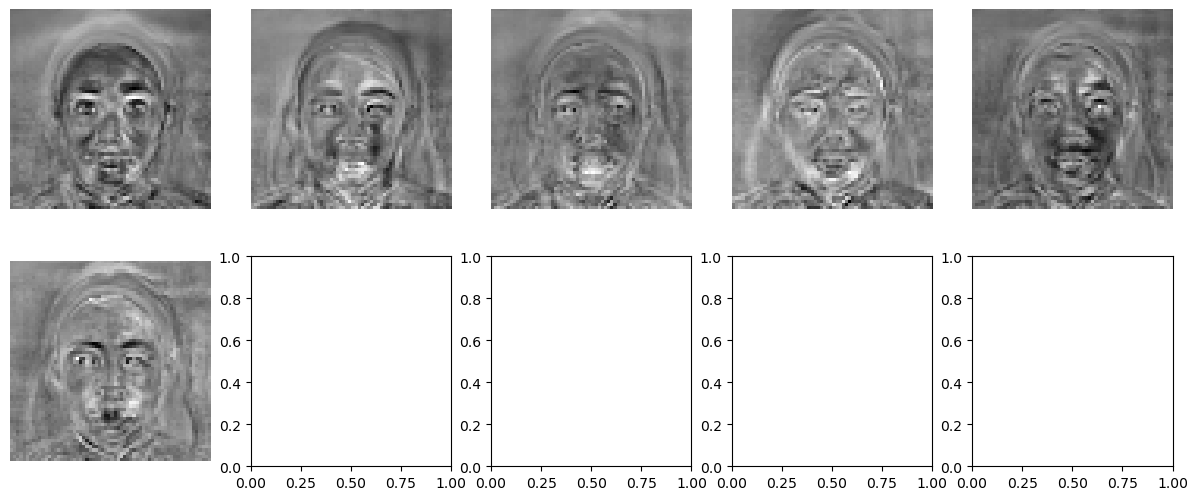

In [22]:
plot_eigenfaces(eigenfaces)

In [23]:
labels = y
unique_classes = list(set(labels))
reconstructed_images = inverse_transform(transformed_images,components, mean, std)
reconstructed_images = reconstructed_images.reshape(-1, *image_size)

inverse transform images: 


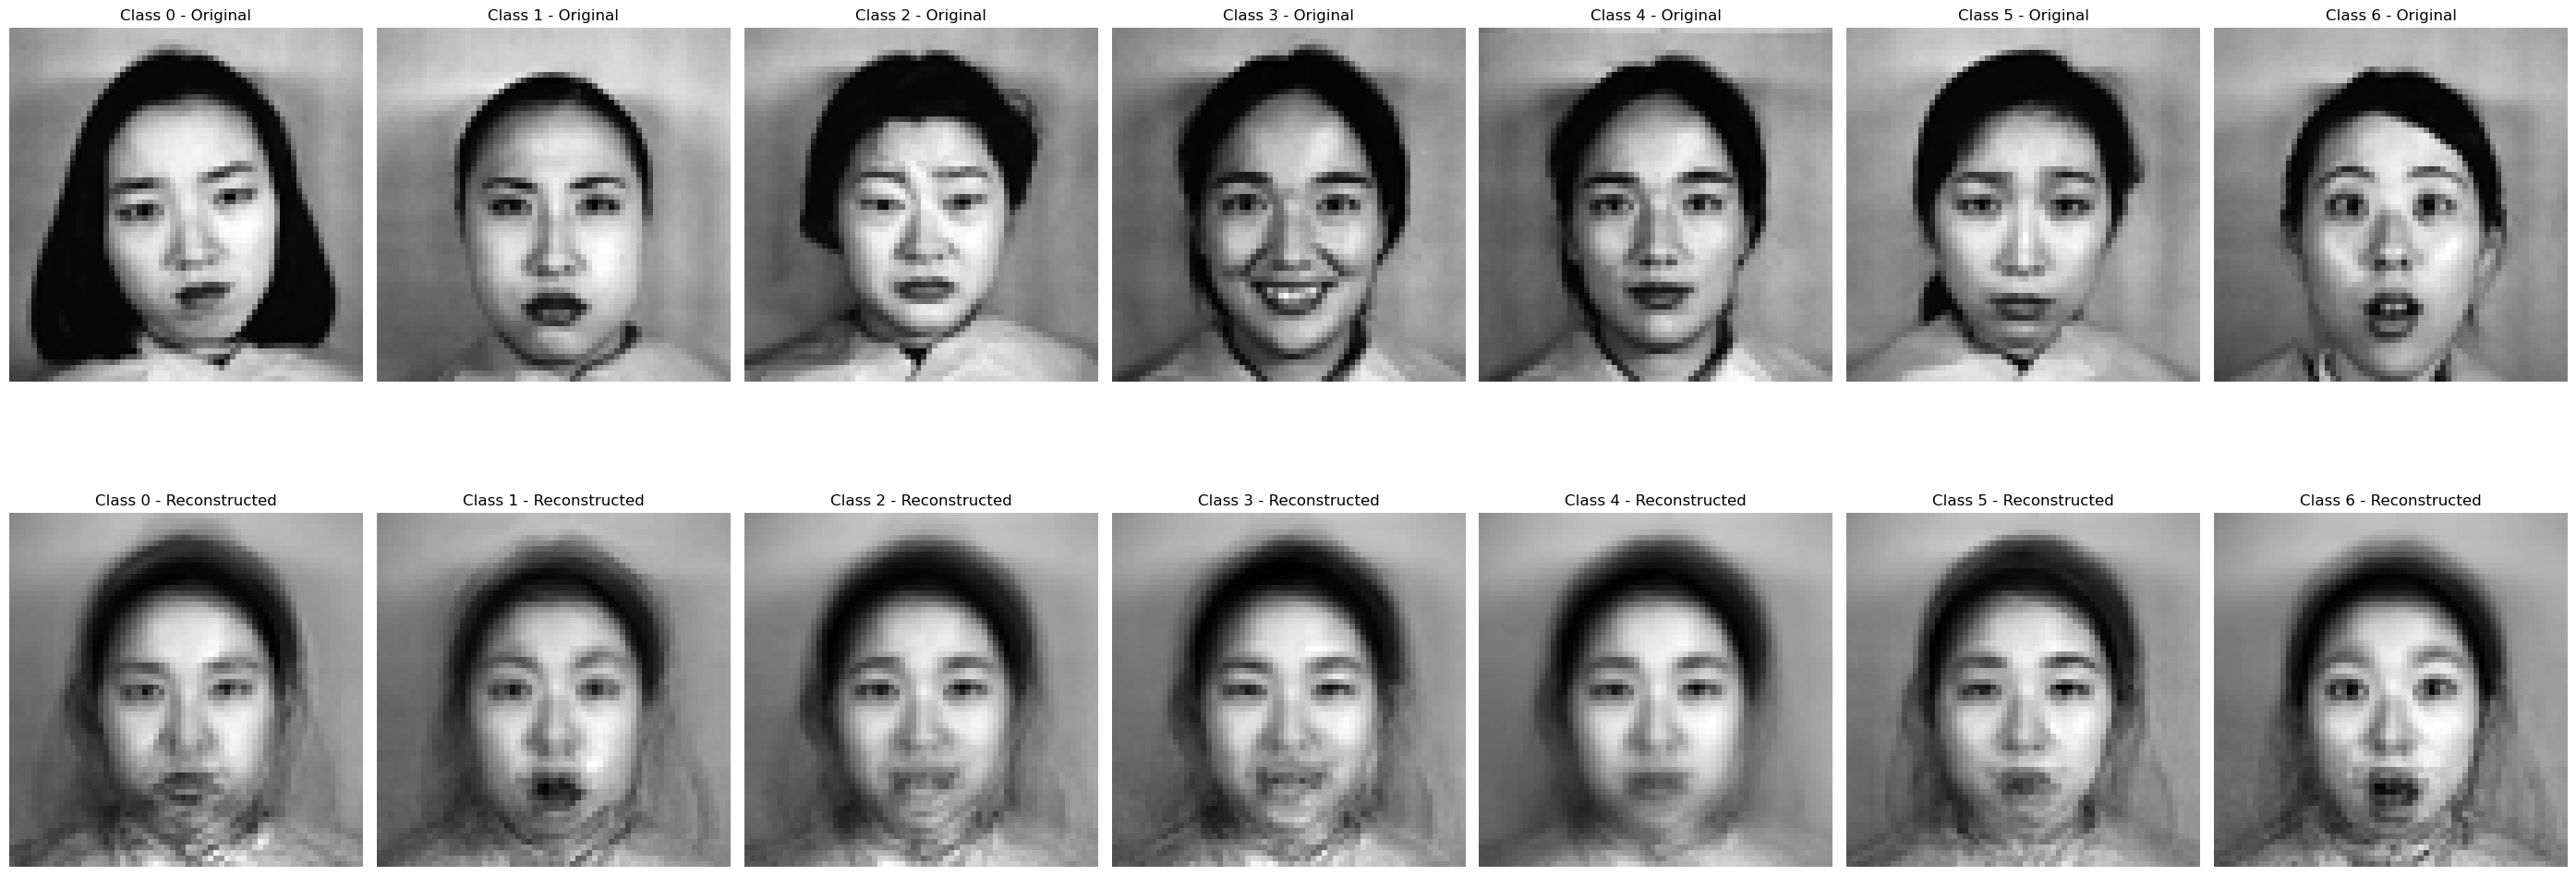

In [24]:
plot_inverse_transformation(reconstructed_images, unique_classes, image_size)

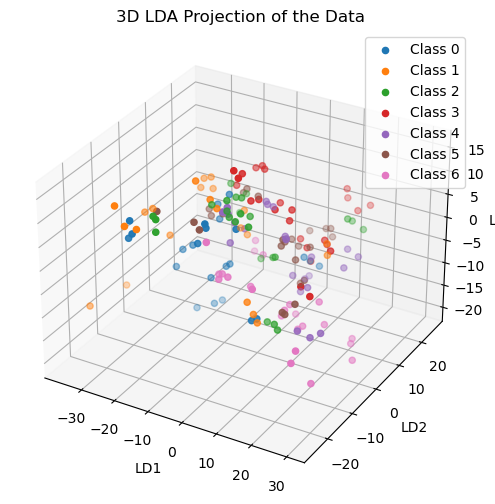

In [40]:
if transformed_images.shape[1] >= 3:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    for label in np.unique(labels):
        ax.scatter(transformed_images[labels == label, 0], transformed_images[labels == label, 1], transformed_images[labels == label, 2], label=f'Class {label}')
    ax.set_title('3D LDA Projection of the Data')
    ax.set_xlabel('LD1')
    ax.set_ylabel('LD2')
    ax.set_zlabel('LD3')
    plt.legend()
    plt.show()
else:
    print("Cannot plot in 3D as there are less than 3 dimensions.")

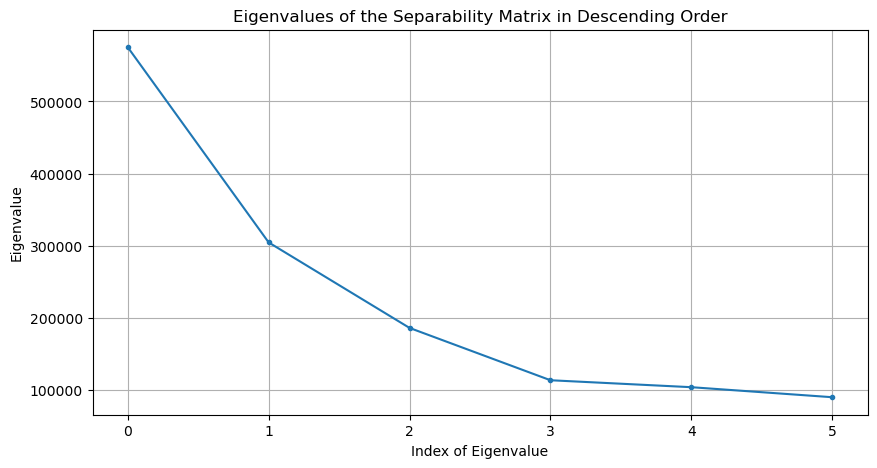

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(eigenvalues[:len(unique_classes) - 1], 'o-', markersize=3)
plt.title('Eigenvalues of the Separability Matrix in Descending Order')
plt.xlabel('Index of Eigenvalue')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

In [27]:
X_train, X_test, y_train, y_test = train_test_split(transformed_images, y, test_size=0.3, random_state=42)

In [31]:
qda_model = QuadraticDiscriminantAnalysis()
qda_model.fit(X_train, y_train)
y_pred = qda_model.predict_likelihood(X_test)
accuracy_value = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_value:.2f}")

Accuracy: 0.55


In [32]:
gnb = GaussianNaiveBayes()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
accuracy_value = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy_value:.2f}")

Accuracy: 0.41


In [38]:
max_num_features = min(len(np.unique(y)), X_standardized.shape[1])
num_features = range(1, max_num_features )

feature_numbers = []
accuracies = []

for num in num_features:
    W = eigenvectors[:, :num]
    X_lda = X_standardized.dot(W)
    X_train, X_test, y_train, y_test = train_test_split(X_lda, labels, test_size=0.3, random_state=42)
    qda = QuadraticDiscriminantAnalysis()
    qda.fit(X_train, y_train)
    y_pred = qda.predict_likelihood(X_test)
    accuracy_value = accuracy_score(y_test,y_pred)
    feature_numbers.append(num)
    accuracies.append(accuracy_value)

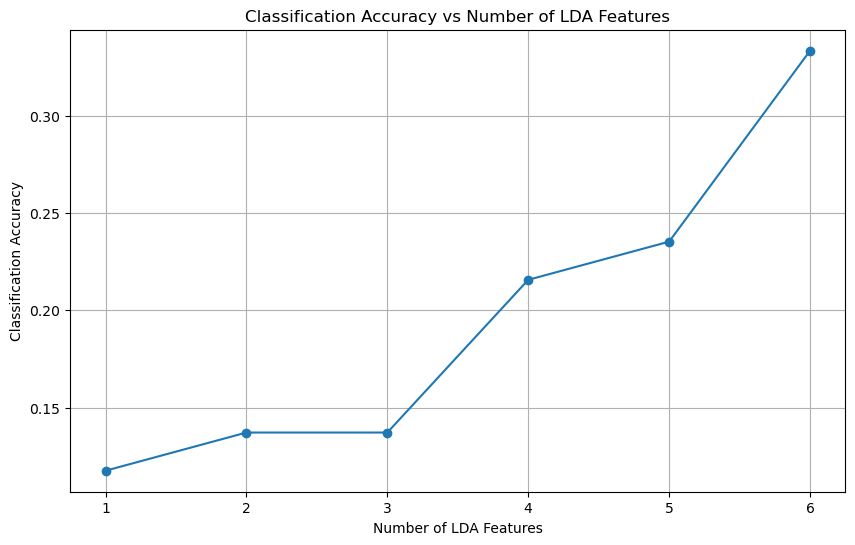

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(feature_numbers, accuracies, marker='o')
plt.title('Classification Accuracy vs Number of LDA Features')
plt.xlabel('Number of LDA Features')
plt.ylabel('Classification Accuracy')
plt.grid(True)
plt.show()